In [1]:
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

### Helper functions

In [3]:
def generateRandomDf(size=100, feature_powers=[1,2,3], target_powers=[1,2,3]):
    '''Generate a random data frame where target is a linear combination
        of powers of a random normal variable'''
    
    X = np.random.normal(size=size)
    e = np.random.normal(size=size)

    data = {}
    for p in feature_powers:
        data[f"X{p}"] = np.power(X, p)

    betas = np.random.normal(size=len(feature_powers)+1)
    data["Y"] = betas[0]
    
    for i, power in enumerate(target_powers):
        data["Y"] += (betas[i+1] * np.power(X, power))
            
    data["Y"] += e
    
    df = pd.DataFrame.from_dict(data)
    return df

def fitModel(X, y):
    '''Fit OLS model'''
    X = sm.add_constant(X)
    result = sm.OLS(y, X).fit()
    return result

def evaluateOLS(X, y, model):
    '''Evaluate OLS model'''
    X = sm.add_constant(X)
    test_preds = model.predict(X)
    mse = mean_squared_error(test_preds, y)
    return mse
    
def highlightRow(row, target_col, val):
    '''Highlight a row containing
        best value of DataFrame'''
    if row[target_col] == val:
        return ['background-color: lightgreen'] * row.shape[0]
        #return ['background-color: lightgreen']*5
    else:
        return ['background-color: white'] * row.shape[0]
        #return ['background-color: white']*5
    
def subsetSelection(X_train, y_train, max_k, criteria, maximize=False):
    '''Perform best subset selection on a DataFrame. All possible feature
        combination sizes ranging from 1 to max_k are tried, and features
        are selected according to criteria that can be maximized or minimized'''
    model_results = {}
    models = [None] * (max_k+1)
    
    for k in range(1, max_k+1):
        best_val = float('inf')
        print(f"Performing subset selection for k = {k}")
        for sub_features in itertools.combinations(X_train.columns, k):
            model = fitModel(X_train[list(sub_features)], y_train)
            result = {"RSS": model.ssr, "R2": model.rsquared_adj,
                      "AIC": model.aic, "BIC": model.bic,
                      "Features": list(sub_features)}
            
            # If we are maximizing, multiply by -1 and minimize
            curr_val = result[criteria] if not maximize else -1*result[criteria]
            
            if(curr_val < best_val):
                model_results[k] = result
                best_val = curr_val
                models[k] = model
                
    results_df = pd.DataFrame.from_dict(model_results).T
    return results_df, models

# 8. In this exercise, we will generate simulated data, and will then use this data to perform best subset selection.

#### (a) Use the rnorm() function to generate a predictor X of length n = 100, as well as a noise vector ϵ of length n = 100.
#### (b) Generate a response vector Y of length n = 100 according to the model Y = β0 + β1X + β2X2 + β3X3 + ϵ, where β0, β1, β2, and β3 are constants of your choice.

In [6]:
feature_powers = np.arange(1, 11)
target_powers = np.arange(1, 4)

df = generateRandomDf(feature_powers=feature_powers, target_powers=target_powers)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,1.513933,2.291993,3.469923,5.253231e+00,7.953039e+00,1.204037e+01,1.822831e+01,2.759643e+01,4.177915e+01,6.325083e+01,-2.748083
1,1.557246,2.425016,3.776346,5.880701e+00,9.157699e+00,1.426079e+01,2.220756e+01,3.458264e+01,5.385369e+01,8.386346e+01,-2.994579
2,-1.358525,1.845589,-2.507279,3.406200e+00,-4.627407e+00,6.286447e+00,-8.540294e+00,1.160220e+01,-1.576188e+01,2.141290e+01,-2.957534
3,0.011749,0.000138,0.000002,1.905593e-08,2.238915e-10,2.630541e-12,3.090670e-14,3.631283e-16,4.266460e-18,5.012740e-20,1.217420
4,-0.394186,0.155383,-0.061250,2.414377e-02,-9.517137e-03,3.751523e-03,-1.478798e-03,5.829215e-04,-2.297795e-04,9.057590e-05,-0.156687


### (c) Use the regsubsets() function to perform best subset selection in order to choose the best model containing the predictors X, X2,...,X10. What is the best model obtained according to Cp, BIC, and adjusted R2?

Using max R2 as the criterion, we correctly obtain the 3 correct features X1, X2, X3 along with X10. Whereas if we minimize AIC, we obtain only X1, X2, and X3. Finally, if we minimize BIC, we obtain best result with X2 and X5. 

In [7]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

results_df, models = subsetSelection(X, y, 10, "R2", True)

best_val = results_df["R2"].max()
results_df.style.apply(highlightRow, axis=1, target_col="R2", 
                                       val=best_val)

Performing subset selection for k = 1
Performing subset selection for k = 2
Performing subset selection for k = 3
Performing subset selection for k = 4
Performing subset selection for k = 5
Performing subset selection for k = 6
Performing subset selection for k = 7
Performing subset selection for k = 8
Performing subset selection for k = 9
Performing subset selection for k = 10


,RSS,R2,AIC,BIC,Features
1,187.123739,0.843399,350.447698,355.658039,['X4']
2,83.489444,0.929409,271.742709,279.558219,"['X2', 'X5']"
3,81.798764,0.930118,271.696901,282.117582,"['X1', 'X2', 'X3']"
4,80.515302,0.930490,272.115414,285.141264,"['X1', 'X2', 'X3', 'X10']"
5,80.131433,0.930085,273.637507,289.268529,"['X1', 'X2', 'X3', 'X4', 'X6']"
6,79.724303,0.929693,275.128135,293.364326,"['X1', 'X2', 'X5', 'X6', 'X8', 'X9']"
7,79.707831,0.928943,277.107472,297.948833,"['X1', 'X2', 'X3', 'X5', 'X6', 'X8', 'X9']"
8,79.672134,0.928195,279.062677,302.509209,"['X1', 'X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9']"
9,79.670435,0.927398,281.060545,307.112247,"['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']"
10,79.670404,0.926583,283.060505,311.717377,"['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']"


In [10]:
results_df, models = subsetSelection(X, y, 10, "AIC")

best_val = results_df["AIC"].min()
results_df.style.apply(highlightRow, axis=1, target_col="AIC", 
                                       val=best_val)

Performing subset selection for k = 1
Performing subset selection for k = 2
Performing subset selection for k = 3
Performing subset selection for k = 4
Performing subset selection for k = 5
Performing subset selection for k = 6
Performing subset selection for k = 7
Performing subset selection for k = 8
Performing subset selection for k = 9
Performing subset selection for k = 10


,RSS,R2,AIC,BIC,Features
1,187.123739,0.843399,350.447698,355.658039,['X4']
2,83.489444,0.929409,271.742709,279.558219,"['X2', 'X5']"
3,81.798764,0.930118,271.696901,282.117582,"['X1', 'X2', 'X3']"
4,80.515302,0.930490,272.115414,285.141264,"['X1', 'X2', 'X3', 'X10']"
5,80.131433,0.930085,273.637507,289.268529,"['X1', 'X2', 'X3', 'X4', 'X6']"
6,79.724303,0.929693,275.128135,293.364326,"['X1', 'X2', 'X5', 'X6', 'X8', 'X9']"
7,79.707831,0.928943,277.107472,297.948833,"['X1', 'X2', 'X3', 'X5', 'X6', 'X8', 'X9']"
8,79.672134,0.928195,279.062677,302.509209,"['X1', 'X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9']"
9,79.670435,0.927398,281.060545,307.112247,"['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']"
10,79.670404,0.926583,283.060505,311.717377,"['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']"


In [11]:
results_df, models = subsetSelection(X, y, 10, "BIC")

best_val = results_df["BIC"].min()
results_df.style.apply(highlightRow, axis=1, target_col="BIC", 
                                       val=best_val)

Performing subset selection for k = 1
Performing subset selection for k = 2
Performing subset selection for k = 3
Performing subset selection for k = 4
Performing subset selection for k = 5
Performing subset selection for k = 6
Performing subset selection for k = 7
Performing subset selection for k = 8
Performing subset selection for k = 9
Performing subset selection for k = 10


,RSS,R2,AIC,BIC,Features
1,187.123739,0.843399,350.447698,355.658039,['X4']
2,83.489444,0.929409,271.742709,279.558219,"['X2', 'X5']"
3,81.798764,0.930118,271.696901,282.117582,"['X1', 'X2', 'X3']"
4,80.515302,0.930490,272.115414,285.141264,"['X1', 'X2', 'X3', 'X10']"
5,80.131433,0.930085,273.637507,289.268529,"['X1', 'X2', 'X3', 'X4', 'X6']"
6,79.724303,0.929693,275.128135,293.364326,"['X1', 'X2', 'X5', 'X6', 'X8', 'X9']"
7,79.707831,0.928943,277.107472,297.948833,"['X1', 'X2', 'X3', 'X5', 'X6', 'X8', 'X9']"
8,79.672134,0.928195,279.062677,302.509209,"['X1', 'X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9']"
9,79.670435,0.927398,281.060545,307.112247,"['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']"
10,79.670404,0.926583,283.060505,311.717377,"['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']"


### (e) Now fit a lasso model to the simulated data, again using X, X2, ...,X10 as predictors. Use cross-validation to select the optimal value of λ

In [12]:
alphas = np.power(10, np.linspace(-3, 2, num=100))

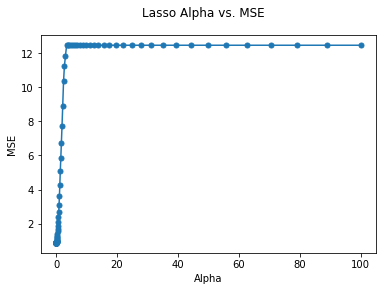

In [13]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                           ('lasso', LassoCV(alphas=alphas, cv=10, random_state=4,max_iter=7000))])
lasso_pipeline = lasso_pipeline.fit(X, y)

lasso_cv_mse = np.mean(lasso_pipeline['lasso'].mse_path_,axis=1)

fig = plt.figure()
plt.plot(lasso_pipeline['lasso'].alphas_, lasso_cv_mse, marker='.', markersize=10)
fig.suptitle('Lasso Alpha vs. MSE')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

### (f) Now generate a response vector Y according to the model Y = β0 + β7X7 + ϵ, and perform best subset selection and the lasso. Discuss the results obtained.

With Best subset selection and using AIC as criterion, we can see that the best performing model correctly contains only X7.

In [14]:
df = generateRandomDf(feature_powers=feature_powers, target_powers=[7])
X, y = df.iloc[:, :-1], df.iloc[:, -1]

In [15]:
X.shape

(100, 10)

In [16]:
results, _ = subsetSelection(X, y, 10, "AIC")

best_val = results["AIC"].min()
results.style.apply(highlightRow, axis=1, target_col="AIC", val=best_val)

Performing subset selection for k = 1
Performing subset selection for k = 2
Performing subset selection for k = 3
Performing subset selection for k = 4
Performing subset selection for k = 5
Performing subset selection for k = 6
Performing subset selection for k = 7
Performing subset selection for k = 8
Performing subset selection for k = 9
Performing subset selection for k = 10


,RSS,R2,AIC,BIC,Features
1,85.042071,0.999558,271.585296,276.795637,['X7']
2,84.806304,0.999554,273.307676,281.123187,"['X4', 'X7']"
3,84.557861,0.999551,275.014293,285.434974,"['X5', 'X7', 'X9']"
4,84.076428,0.999549,276.443312,289.469163,"['X1', 'X3', 'X5', 'X7']"
5,82.900588,0.999550,277.034903,292.665924,"['X4', 'X6', 'X7', 'X8', 'X10']"
6,82.077347,0.999550,278.036894,296.273086,"['X2', 'X5', 'X6', 'X7', 'X8', 'X9']"
7,81.311475,0.999549,279.099403,299.940764,"['X1', 'X2', 'X5', 'X6', 'X7', 'X9', 'X10']"
8,81.301768,0.999545,281.087464,304.533996,"['X1', 'X2', 'X3', 'X5', 'X6', 'X7', 'X9', 'X10']"
9,81.298305,0.999540,283.083205,309.134907,"['X1', 'X2', 'X3', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']"
10,81.298297,0.999534,285.083195,313.740067,"['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']"


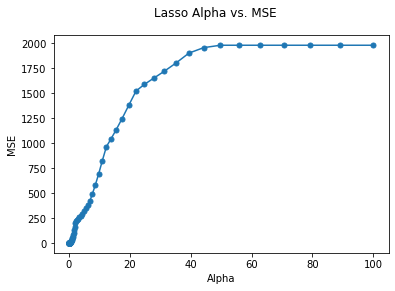

In [17]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                           ('lasso', LassoCV(alphas=alphas, cv=10, random_state=4,max_iter=7000))])
lasso_pipeline = lasso_pipeline.fit(X, y)

lasso_cv_mse = np.mean(lasso_pipeline['lasso'].mse_path_,axis=1)

fig = plt.figure()
plt.plot(lasso_pipeline['lasso'].alphas_, lasso_cv_mse, marker='.', markersize=10)
fig.suptitle('Lasso Alpha vs. MSE')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

Using Lasso regression, 7 coefficients are zeroed out and the largest coefficient magnitude is X7 which was used to generate the data. 

In [18]:
lasso_pipeline['lasso'].coef_

array([-0.        , -0.        ,  0.        , -0.        ,  0.62375746,
       -0.        , 42.73831382, -0.        ,  0.69185109,  0.        ])

#  9. In this exercise, we will predict the number of applications received using the other variables in the College data set

In [19]:
college_df = pd.read_csv(r'datasets\college.csv')
college_df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [20]:
errors = {}

### (a) Split the data set into a training set and a test set

In [21]:
from sklearn.model_selection import train_test_split

college_df['Private'] = college_df['Private'].map({'Yes':1,'No':0})
X, y = college_df.drop(columns=["Apps"]), college_df["Apps"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### (b) Fit a linear model using least squares on the training set, and report the test error obtained.

In [22]:
result = fitModel(X_train, y_train)

OLS_mse = evaluateOLS(X_test, y_test, result)
print(f"OLS MSE = {OLS_mse}")

OLS MSE = 1022430.0889253949


In [23]:
errors["OLS"] = OLS_mse

### (c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained

In [24]:
ridge_pipeline = Pipeline([('scaler', StandardScaler()),
                           ('ridge', RidgeCV(alphas=alphas, store_cv_values=True))])

ridge_pipeline = ridge_pipeline.fit(X_train, y_train)

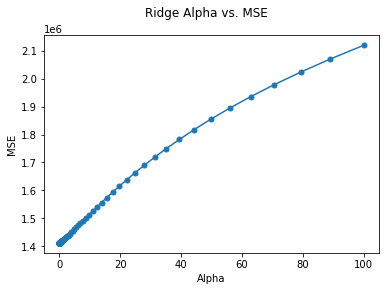

In [25]:
ridge_cv_error = np.mean(ridge_pipeline['ridge'].cv_values_,axis=0)

fig = plt.figure()
plt.plot(alphas, ridge_cv_error, marker='.', markersize=10)
fig.suptitle('Ridge Alpha vs. MSE')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.show()

In [26]:
ridge_pipeline['ridge'].alpha_

0.001

In [27]:
ridge_preds = ridge_pipeline.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_preds)
print(f"Ridge MSE = {ridge_mse}")

Ridge MSE = 1022420.8708879905


In [28]:
errors["Ridge"] = ridge_mse

### (d) Fit a lasso model on the training set, with λ chosen by crossvalidation. Report the test error obtained, along with the number of non-zero coefficient estimates

Text(0, 0.5, 'MSE')

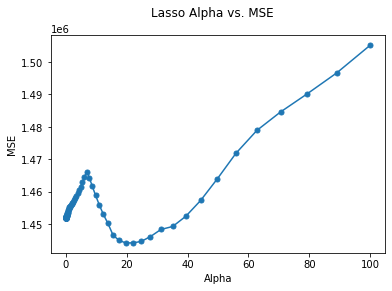

In [29]:
lasso_pipeline = Pipeline([('scaler', StandardScaler()),
                           ('lasso', LassoCV(alphas=alphas, cv=10, random_state=4,max_iter=7000))])
lasso_pipeline = lasso_pipeline.fit(X_train, y_train)

lasso_cv_mse = np.mean(lasso_pipeline['lasso'].mse_path_,axis=1)

fig = plt.figure()
plt.plot(lasso_pipeline['lasso'].alphas_, lasso_cv_mse, marker='.', markersize=10)
fig.suptitle('Lasso Alpha vs. MSE')
plt.xlabel('Alpha')
plt.ylabel('MSE')

In [30]:
lasso_preds = lasso_pipeline.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_preds)
print(f"Lasso MSE = {lasso_mse}")

Lasso MSE = 1007348.995897335


In [31]:
errors["Lasso"] = lasso_mse

In [32]:
count_zeros = lasso_pipeline['lasso'].coef_.shape[0] - np.count_nonzero(lasso_pipeline['lasso'].coef_)
print(f"{count_zeros} Coeffs are zeroed out")

5 Coeffs are zeroed out


### (e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

In [33]:
def tune_PCA(X, y, cv=10, visualize=True):
    results = {}
    pca_pipeline = Pipeline([('scaler', StandardScaler()),
                           ('pca', PCA())])
    X_PCA = pca_pipeline.fit_transform(X)
    kf = KFold(n_splits=cv)
    
    for m in range(1, X_PCA.shape[1]+1):
        mse = 0
        
        for train_index, test_index in kf.split(X_PCA):
            X_train, X_test = X_PCA[train_index, :m], X_PCA[test_index, :m]
            y_train, y_test = y[train_index], y[test_index]
            ols = fitModel(X_train, y_train)
            X_test = sm.add_constant(X_test)
            test_preds = ols.predict(X_test)
            OLS_mse = mean_squared_error(y_test, test_preds)
            mse += OLS_mse
        
        mse = mse / cv
        results[m] = mse
    
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=["MSE"])
    
    if visualize:
        ax = results_df.plot(y='MSE', use_index=True, marker='.', markersize=10) 
        ax.set_xlabel("Number of Components")
        ax.set_ylabel("MSE")
        
    return results_df

PCA MSE = 1451962.4913853537


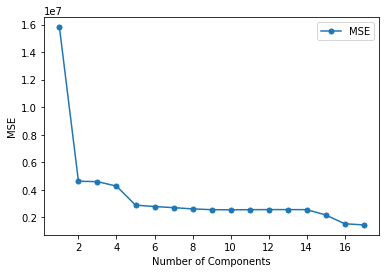

In [34]:
PCR_mse_df = tune_PCA(X_train.to_numpy(), y_train.values, visualize=True)
PCR_mse = PCR_mse_df.MSE.min()
print(f"PCA MSE = {PCR_mse}")

In [35]:
errors["PCR"] = PCR_mse

### (g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?
OLS and Ridge perform very similarly, whereas Lasso outperforms both because of the fact that there are only a few significant predictors and the rest are noise. PCR Performs the worst.

In [36]:
print(errors)

{'OLS': 1022430.0889253949, 'Ridge': 1022420.8708879905, 'Lasso': 1007348.995897335, 'PCR': 1451962.4913853537}


## 10 We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.

###  (a) Generate a data set with p = 20 features, n = 1,000 observations, and an associated quantitative response vector generated according to the model Y = Xβ + ϵ, where β has some elements that are exactly equal to zero.

In [37]:
X = np.random.normal(size = (1000,20))
e = np.random.normal(size=1000)

# generate beta array of random integers, along with a flag
# that equals 0 20% of the time to randomly remove some coeffs
beta = np.random.randint(0, high=10,size=20)
flag = np.random.rand(20) > 0.2
beta = beta*flag

y = np.matmul(X, beta) + e

In [38]:
beta

array([7, 0, 5, 9, 4, 0, 7, 6, 7, 0, 0, 1, 0, 5, 3, 4, 3, 5, 6, 0])

In [39]:
colnames = [f"X{i}" for i in range(20)] + ['y']
df = pd.DataFrame(np.hstack([X,y.reshape(-1, 1)]), columns=colnames)

df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X11,X12,X13,X14,X15,X16,X17,X18,X19,y
0,-1.126611,-0.319136,0.500531,1.578808,0.700911,0.968563,-0.742904,-0.420187,2.016318,-0.121779,...,1.157855,-0.385416,0.868077,-1.176760,0.599042,-1.344577,-0.093816,1.033445,0.209054,24.960729
1,-0.312699,-1.428976,-0.853966,1.018643,-1.479348,0.207009,-0.528124,-0.573449,-1.390150,0.319142,...,0.342109,-0.372296,-0.059831,0.479188,-0.211668,1.365923,0.084158,-0.452968,0.339294,-17.983652
2,1.043335,0.292842,1.400071,1.830960,-0.867040,1.055664,-0.102095,-0.715165,-0.526394,-0.272214,...,-0.908469,0.690682,-0.656983,-1.429279,0.275382,-1.086212,-1.521110,-1.144463,1.874946,-6.067759
3,1.155870,1.169318,0.540074,-0.359075,-0.435027,0.392685,0.174269,-0.148551,-1.057592,-1.098222,...,0.494621,-0.133938,1.319456,-0.322404,1.187387,0.115593,-2.072195,-1.392644,1.031523,-8.208918
4,-0.664142,-0.013147,2.008409,-0.379717,-0.448628,0.061700,-0.555520,0.514919,-1.132503,0.567903,...,0.910683,0.158310,-0.186094,-0.782427,1.039611,-0.812827,-0.517905,-0.307918,0.805941,-13.993904


### (b) Split your data set into a training set containing 100 observations and a test set containing 900 observations.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.9)
print(f"train size: {X_train.shape}, test size: {X_test.shape}")

train size: (100, 20), test size: (900, 20)


### (c) Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.

It takes a very long time so I am limiting subset size to 7.

In [41]:
results, models = subsetSelection(X_train, y_train, 7, "AIC")

Performing subset selection for k = 1
Performing subset selection for k = 2
Performing subset selection for k = 3
Performing subset selection for k = 4
Performing subset selection for k = 5
Performing subset selection for k = 6
Performing subset selection for k = 7


In [42]:
best_val = results["AIC"].min()
results.style.apply(highlightRow, axis=1, target_col="AIC", val=best_val)

,RSS,R2,AIC,BIC,Features
1,34946.310794,0.185058,873.427507,878.637847,['X3']
2,26505.964589,0.375513,847.783195,855.598705,"['X3', 'X6']"
3,21357.248119,0.491577,828.185333,838.606014,"['X3', 'X6', 'X7']"
4,17486.845282,0.579332,810.191106,823.216957,"['X3', 'X6', 'X7', 'X8']"
5,13583.019286,0.669767,786.928259,802.559280,"['X3', 'X6', 'X7', 'X8', 'X17']"
6,10945.147565,0.731039,767.335837,785.572029,"['X3', 'X6', 'X7', 'X8', 'X13', 'X17']"
7,7832.002140,0.805448,735.868034,756.709395,"['X0', 'X3', 'X6', 'X7', 'X8', 'X17', 'X18']"


### (d) Plot the test set MSE associated with the best model of each size.

In [43]:
model_errors = []

for i, m in enumerate(models[1:]):
    features = results.iloc[i, -1]
    mse = evaluateOLS(X_test[features], y_test, m)
    model_errors.append(mse)

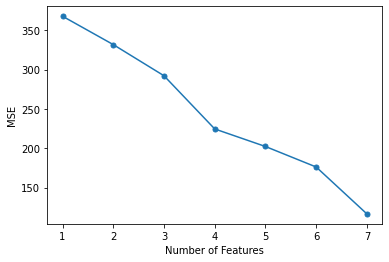

In [44]:
idxs = np.arange(len(model_errors)) + 1
plt.plot(idxs, model_errors, marker='.', markersize=10)
plt.xlabel("Number of Features")
plt.ylabel('MSE')
plt.show()

### (e) For which model size does the test set MSE take on its minimum value? Comment on your results.

The minimum test error is achieved with model size of 7, it is possible that including more variables would have decreased the error further but it is very computationally expensive to di this via subset selection. 

### (f) How does the model at which the test set MSE is minimized compare to the true model used to generate the data? Comment on the coefficient values.

Coefficient values are generally close to the true ones, and the differences are probably due to the addition of the noise.

In [45]:
# Best model was the last one, and we exclude the constant
model_params = models[-1].params.values[1:]

In [46]:
features = results.iloc[-1, -1]
feature_idxs = [int(x[1:]) for x in features]
feature_idxs

[0, 3, 6, 7, 8, 17, 18]

In [47]:
true_params = [beta[idx] for idx in feature_idxs]
params_df = pd.DataFrame({"True Param": true_params, "Estimated Param": model_params})
params_df

,True Param,Estimated Param
0,7,5.739974
1,9,9.633738
2,7,7.988455
3,6,6.377402
4,7,5.656691
5,5,6.007403
6,6,6.588187
